# 군집 평가(Cluster Evaluation)
- 붓꽃 데이터 세트의 경우 결괏값에 품종을 뜻하는 타깃 레이블이 있었다. 그래서 군집화된 결과를 이 레이블과 비교해 군집화가 얼마나 효율적으로 됐는지 짐작할 수 있었다. 하지만 대부분의 군집화 데이터 세트는 비교할 만한 타깃 레이블을 가지고 있지 않다.
- 비지도학습의 특성상 어떠한 지표라도 정확하게 성능을 평가하기는 어렵다.
- 실루엣 분석 : 군집화가 효율적으로 잘 됐는지 평가할 수 있는 지표 즉 군집화의 성능을 평가하는 대표적인 방법으로 사용

## 실루엣 분석
- 각 군집 간의 거리가 얼마나 효율적으로 분리돼 있는지를 나타냄
- 효율적: 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 가깝게 잘 뭉쳐 있을때를 의미
- 군집화가 잘 될수록 개별 군집은 비슷한 정도의 여유공간을 가지고 떨어져 있다.
- 실루엣 분석은 실루엣 계수를 기반으로 한다.

### 실루엣 계수
- 개별 데이터가 가지는 군집화 지표
- 해당 데이터가 같은 군집 내의 데이터와 얼마나 가깝게 군집화돼어 있고, 다른 군집에 있는 데이터와는 얼마나 분리돼 있는지른 나타내는 지표
- (참고) https://ariz1623.tistory.com/224

### 붓꽃(Iris) 데이터 셋을 이용한 클러스터 평가
- 실루엣분석 : 각 군집간의 거리가 얼마나 효율적으로 분리되 있는지
- 실루엣 계수(silhouette coefficient) : -1 ~ 1 사이 값. 1에 가까울수록 좋다.
-  1에 가까울수록 근처의 군집과 떨어져 있다는 것, - 값은 아예 다른 군집에 데이터 포인트가 할당됐음을 뜻함.

In [1]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(irisDF)

irisDF['cluster'] = kmeans.labels_

In [2]:
# iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

silhouette_samples( ) return 값의 shape (150,)


In [3]:
# irisDF에 실루엣 계수 컬럼 추가
irisDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(iris.data, irisDF['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

irisDF.head(3)

붓꽃 데이터셋 Silhouette Analysis Score:0.553


,sepal_length,sepal_width,petal_length,petal_width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852955
1,4.9,3.0,1.4,0.2,1,0.815495
2,4.7,3.2,1.3,0.2,1,0.829315


In [4]:
# 군집별 평균 실루엣 계수 값
irisDF.groupby('cluster')['silhouette_coeff'].mean()
#(결과) 1번 군집은 실루엣 계수 평균 값이 약 0.79인데 반해, 
#       0번은 약 0.41,  2번은 0.45로 상대적으로 평균값이 1번에 비해 낮다.

cluster
0    0.451105
1    0.798140
2    0.417320
Name: silhouette_coeff, dtype: float64

### 클러스터별 평균 실루엣 계수의 시각화를 통한 클러스터 개수 최적화 방법
- 전체 데이터의 평균 실루엣 계수 값이 높다고 해서 반드시 최적의 군집 개수로 군집화가 잘 됐다고 볼 수는 없다.
  특정 군집 내 실루엣 계수 값만 너무 높고, 다른 군집은 내부 데이터끼리의 거리가 너무 떨어져 있어 실루엣 계수 값이 낮아져도 평균적으로 높은 값을 가질 수 있기 때문이다.
- 개별 군집별로 적당히 분리된 거리를 유지하면서도 군집 내의 데이터가 서로 뭉쳐 있는 경우에 K-Mean의 평균 적절한 군집개수가 설정됐다고 판단할 수 있다.

In [5]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

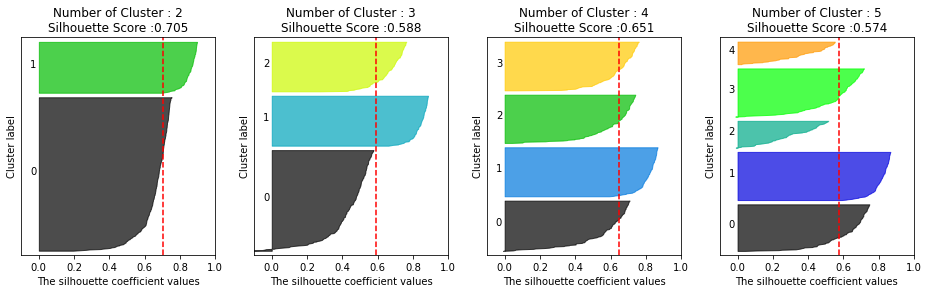

In [6]:
# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], X)

(해석)
X 축: 실루엣 계수 값
Y 축: 개별 군집과 이에 속하는 데이터
- Number of Cluster : 2 일 경우(2개로 군집을 나눌 경우)<br>
  개별 군집은 Y축에 숫자값으로 0, 1로 표시<br>
  해당 데이터의 크기는 Y 축의 높이로 추측 할 수 있다. (0라벨의 데이터가 많음을 알 수 있다)<br>
  1번 군집의 모든 데이터는 평균 실루엣 계수 값 이상이다.<br>
  0번 군집의 경우는 평균 실루엣 계수 값보다 적은 데이터 값이 매우 많다.
- Number of Cluster : 3 일 경우(3개로 군집을 나눌 경우)
  개별 군집은 Y축에 숫자값으로 0, 1, 2로 표시<br>
  1번, 2번 군집의 경우 평균보다 높은 실루엣 계수 값을 가지고 있다.<br>
  0번 군집의 경우는 평균 실루엣 계수 값보다 낮다.
- Number of Cluster : 4 일 경우(4개로 군집을 나눌 경우)<br>
  개별 군집은 Y축에 숫자값으로 0, 1, 2, 3로 표시<br>
  개별 군집의평균 실루엣 값이 비교적 균일하게 위치하고 있다.<br><br>
<b>(결론) 4개의 군집일때 가장 최적이 됨을 알 수 있다.</b>

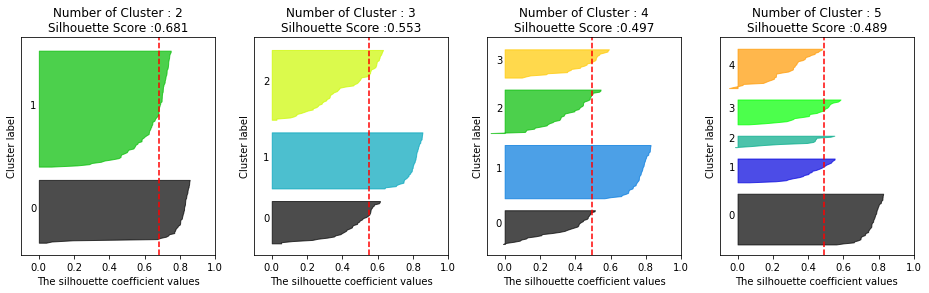

In [7]:
from sklearn.datasets import load_iris

iris=load_iris()
visualize_silhouette([ 2, 3, 4,5 ], iris.data)

(해석)
1. 실루엣 계수 값 : 2개로 군집화한 것이 가장 크다
2. 개별 군집들 간의 실루엣 계수의 편차가 2개로 군집화 한 것이 가작 적다.

(결론)<br>
<b>꽃 데이터를 K-Means 로 군집화할 경우는 군집 개수를 2개로 하는 것이 가장 좋아 보인다.</b>